# 04 - Baseline Models

Goal: establish baseline classifiers without heavy tuning.

Models:
- Logistic Regression (with class weights)
- Decision Tree (with class weights)

Metrics: Precision, Recall, F1, ROC-AUC, Confusion Matrix.


In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from pathlib import Path

PROCESSED_DIR = Path('../data/processed')
X_train = pd.read_csv(PROCESSED_DIR / 'X_train_scaled.csv')
X_test = pd.read_csv(PROCESSED_DIR / 'X_test_scaled.csv')
y_train = pd.read_csv(PROCESSED_DIR / 'y_train.csv').squeeze()
y_test = pd.read_csv(PROCESSED_DIR / 'y_test.csv').squeeze()

# Class weights for imbalance
neg, pos = y_train.value_counts()[0], y_train.value_counts()[1]
class_weight = {0: neg/len(y_train), 1: pos/len(y_train)}

models = {
    'log_reg': LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1, random_state=42),
    'decision_tree': DecisionTreeClassifier(class_weight='balanced', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]
    results[name] = {
        'report': classification_report(y_test, preds, output_dict=True),
        'roc_auc': roc_auc_score(y_test, probs),
        'confusion': confusion_matrix(y_test, preds)
    }

results

c:\Users\Faheem\Desktop\Github\bot\FYP2025-Fraud-Detection\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


{'log_reg': {'report': {'0': {'precision': 0.9906868451688009,
    'recall': 0.5587373737373738,
    'f1-score': 0.7145025349565667,
    'support': 19800.0},
   '1': {'precision': 0.010868334654137892,
    'recall': 0.48,
    'f1-score': 0.021255396878113585,
    'support': 200.0},
   'accuracy': 0.55795,
   'macro avg': {'precision': 0.5007775899114694,
    'recall': 0.5193686868686869,
    'f1-score': 0.36787896591734015,
    'support': 20000.0},
   'weighted avg': {'precision': 0.9808886600636543,
    'recall': 0.55795,
    'f1-score': 0.7075700635757821,
    'support': 20000.0}},
  'roc_auc': 0.512614898989899,
  'confusion': array([[11063,  8737],
         [  104,    96]])},
 'decision_tree': {'report': {'0': {'precision': 0.9898804047838087,
    'recall': 0.9781818181818182,
    'f1-score': 0.9839963420210334,
    'support': 19800.0},
   '1': {'precision': 0.004608294930875576,
    'recall': 0.01,
    'f1-score': 0.006309148264984227,
    'support': 200.0},
   'accuracy': 0.9685,

Store these baseline results for later comparison in `07_model_evaluation.ipynb`.

In [7]:
import pandas as pd

# Build a summary table from the `results` dict
rows = []
for name, res in results.items():
    rep = res["report"]
    rows.append({
        "model": name,
        "precision_0": rep["0"]["precision"],
        "recall_0":    rep["0"]["recall"],
        "f1_0":        rep["0"]["f1-score"],
        "precision_1": rep["1"]["precision"],
        "recall_1":    rep["1"]["recall"],
        "f1_1":        rep["1"]["f1-score"],
        "roc_auc":     res["roc_auc"],
    })

summary_df = pd.DataFrame(rows)
summary_df

,model,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1,roc_auc
0,log_reg,0.990687,0.558737,0.714503,0.010868,0.48,0.021255,0.512615
1,decision_tree,0.989880,0.978182,0.983996,0.004608,0.01,0.006309,0.494091


In [8]:
# Confusion matrices per model
confusion_list = []
for name, res in results.items():
    cm = res['confusion']
    confusion_list.append({
        'model': name,
        'tn': cm[0, 0],
        'fp': cm[0, 1],
        'fn': cm[1, 0],
        'tp': cm[1, 1],
    })

confusion_df = pd.DataFrame(confusion_list)
confusion_df


,model,tn,fp,fn,tp
0,log_reg,11063,8737,104,96
1,decision_tree,19368,432,198,2


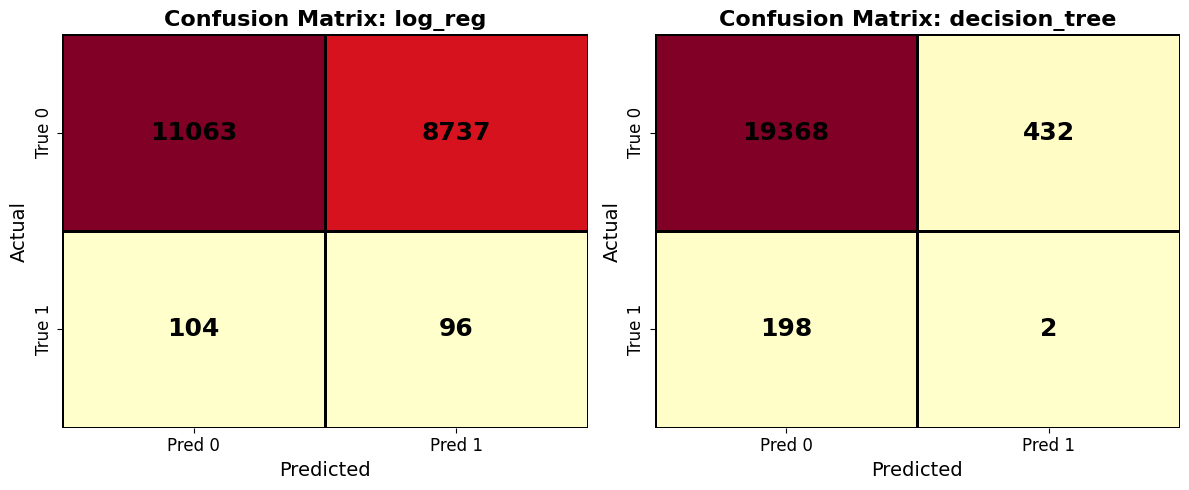

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, len(confusion_df), figsize=(6 * len(confusion_df), 5))

if len(confusion_df) == 1:
    axes = [axes]

for ax, (_, row) in zip(axes, confusion_df.iterrows()):
    cm = [[row['tn'], row['fp']],
          [row['fn'], row['tp']]]
    # Use a diverging color palette for better visual distinction and add thicker linewidths
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='YlOrRd',       # Changed to a high-contrast colormap
        cbar=False, 
        ax=ax,
        xticklabels=['Pred 0', 'Pred 1'], 
        yticklabels=['True 0', 'True 1'],
        linewidths=2, 
        linecolor='black',
        annot_kws={"fontsize": 18, "weight": "bold", "color": "black"}
    )
    ax.set_title(f"Confusion Matrix: {row['model']}", fontsize=16, weight='bold')
    ax.set_xlabel("Predicted", fontsize=14)
    ax.set_ylabel("Actual", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()
